In [1]:
import pandas as pd
import json

def create_dataframe(annotations_path):
    with open(annotations_path, 'r') as file:
        data = json.load(file)

    images = pd.DataFrame(data['images']).rename(columns={'id': 'image_id'})[['image_id', 'file_name']]

    categories = pd.DataFrame(data['categories'])[['id', 'name']]
    categories.rename(columns={'id': 'category_id'}, inplace=True)

    usecols = ['image_id', 'category_id']
    annotations = pd.DataFrame(data['annotations'])[usecols]

    dataframe = annotations.merge(categories, on='category_id').merge(images, on='image_id')[['file_name', 'name']]
    
    return dataframe

In [2]:
train_df = create_dataframe(r'/kaggle/input/food-recognition-2022/raw_data/public_training_set_release_2.0/annotations.json')

In [3]:
import os

splits = ['train', 'validation']

for split in splits:
    root = f'/kaggle/working/dataset/{split}'

    for index, row in train_df.iterrows():
        directory_name = row['name']
        directory_path = os.path.join(root, directory_name)

        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

In [4]:
validation_df = create_dataframe(r'/kaggle/input/food-recognition-2022/raw_data/public_validation_set_2.0/annotations.json')

In [5]:
import os
import shutil

def copy_images_to_destination(base_dir, dataframe, split):
    images_dir = os.path.join(base_dir, 'images')

    for index, row in dataframe.iterrows():
        file_name = row['file_name']
        file_class = row['name']

        dest_dir = os.path.join('/kaggle/working', 'dataset', split, file_class)
        os.makedirs(dest_dir, exist_ok=True)

        source_path = os.path.join(images_dir, file_name)
        destination_path = os.path.join(dest_dir, file_name)

        shutil.copyfile(source_path, destination_path)

    print("Done copying images.")

In [6]:
# copying training images to their respective classes

base_dir = '/kaggle/input/food-recognition-2022/raw_data/public_training_set_release_2.0'
dataframe = train_df
copy_images_to_destination(base_dir, dataframe, 'train')

Done copying images.


In [7]:
# copying validation images to their respective classes

base_dir = '/kaggle/input/food-recognition-2022/raw_data/public_validation_set_2.0'
dataframe = validation_df
copy_images_to_destination(base_dir, dataframe, 'validation')

Done copying images.


In [8]:
from tensorflow.keras.utils import image_dataset_from_directory as ImageDataset

train = ImageDataset(
    directory=r'/kaggle/working/dataset/train',
    label_mode='categorical',
    batch_size=32,
    image_size=(299, 299)
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 70397 files belonging to 498 classes.


In [9]:
validation = ImageDataset(
    directory=r'/kaggle/working/dataset/validation',
    label_mode='categorical',
    batch_size=32,
    image_size=(299, 299)
)

Found 1799 files belonging to 498 classes.


In [10]:
element = validation.as_numpy_iterator().next()

In [11]:
x, y = element
x[0].shape, y[0].shape

((299, 299, 3), (498,))

In [12]:
# import tensorflow as tf
# import keras
# from tensorflow.keras.applications import InceptionResNetV2
# from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     inception = InceptionResNetV2(include_top=False,
#                           weights='imagenet')

#     inception.trainable = False

#     inputs = keras.Input(shape=(None, None, 3))

#     x = preprocess_input(inputs)
#     x = inception(x, training=False)
#     x = keras.layers.GlobalAveragePooling2D()(x)
#     outputs = keras.layers.Dense(498, activation='softmax')(x)

#     model = keras.Model(inputs=inputs, outputs=outputs)

#     model.summary()

#     model.compile(optimizer=tf.keras.optimizers.Adam(l),
#                       loss=tf.keras.losses.CategoricalCrossentropy(),
#                       metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [13]:
#  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [14]:
# history = model.fit(train,
#                     epochs=32,
#                     validation_data=validation,
#                     callbacks=[callback]
#                    )

In [15]:
import tensorflow as tf
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [16]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=(299, 299, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(498, activation="softmax"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 150, 150, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 150, 150, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 residual_unit (ResidualUni  (None, 75, 75, 64)        74240     
 t)                                                              
                                                        

In [18]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train,
                     epochs=5,
                     validation_data=validation,
                   )

Epoch 1/5
2200/2200 [==============================] - 803s 346ms/step - loss: 5.1945 - accuracy: 0.0804 - val_loss: 5.5283 - val_accuracy: 0.0678
Epoch 2/5
2200/2200 [==============================] - 764s 347ms/step - loss: 4.7592 - accuracy: 0.1171 - val_loss: 5.6104 - val_accuracy: 0.0661
Epoch 3/5
2200/2200 [==============================] - 762s 346ms/step - loss: 4.4533 - accuracy: 0.1482 - val_loss: 5.0615 - val_accuracy: 0.1101
Epoch 4/5
2200/2200 [==============================] - 763s 346ms/step - loss: 4.1963 - accuracy: 0.1757 - val_loss: 4.6690 - val_accuracy: 0.1201
Epoch 5/5
2200/2200 [==============================] - 762s 346ms/step - loss: 3.9856 - accuracy: 0.1986 - val_loss: 4.5734 - val_accuracy: 0.1462


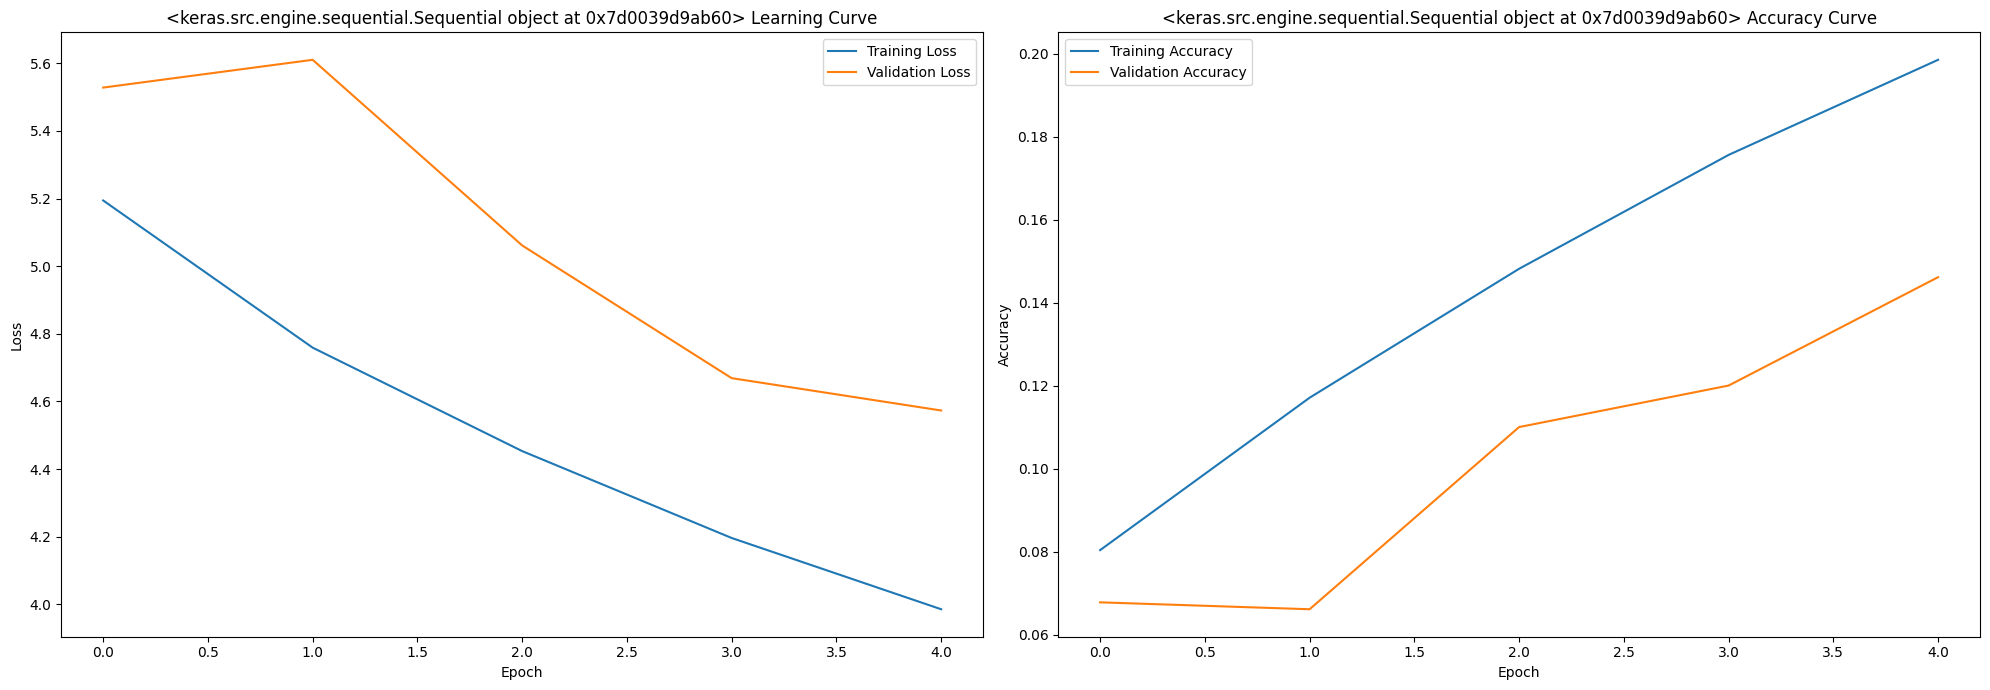

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))  
plot_learning_curves(history, model, axs[0])
plot_accuracy_curves(history, model, axs[1])

plt.tight_layout()
plt.show()

In [20]:
tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(498, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


In [21]:
for layer in base_model.layers:
    layer.trainable = False

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'] 

In [23]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train,
                     epochs=5,
                     validation_data=validation,
                   )

Epoch 1/5
2200/2200 [==============================] - 535s 240ms/step - loss: 20.4233 - accuracy: 0.0290 - val_loss: 21.6252 - val_accuracy: 0.0361
Epoch 2/5
2200/2200 [==============================] - 518s 235ms/step - loss: 18.0852 - accuracy: 0.0445 - val_loss: 21.7018 - val_accuracy: 0.0361
Epoch 3/5
2200/2200 [==============================] - 525s 238ms/step - loss: 17.0868 - accuracy: 0.0535 - val_loss: 21.1131 - val_accuracy: 0.0361
Epoch 4/5
2200/2200 [==============================] - 520s 236ms/step - loss: 16.4875 - accuracy: 0.0609 - val_loss: 20.6799 - val_accuracy: 0.0584
Epoch 5/5
2200/2200 [==============================] - 524s 238ms/step - loss: 15.9927 - accuracy: 0.0678 - val_loss: 22.2167 - val_accuracy: 0.0411


In [24]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10
2200/2200 [==============================] - 1100s 495ms/step - loss: 5.1950 - accuracy: 0.0838 - val_loss: 5.1456 - val_accuracy: 0.0967
Epoch 2/10
2200/2200 [==============================] - 1087s 494ms/step - loss: 4.7292 - accuracy: 0.1196 - val_loss: 5.4439 - val_accuracy: 0.0784
Epoch 3/10
2200/2200 [==============================] - 1082s 492ms/step - loss: 4.5265 - accuracy: 0.1384 - val_loss: 5.0792 - val_accuracy: 0.1012
Epoch 4/10
2200/2200 [==============================] - 1080s 491ms/step - loss: 4.3661 - accuracy: 0.1538 - val_loss: 5.7076 - val_accuracy: 0.0678
Epoch 5/10
2200/2200 [==============================] - 1083s 492ms/step - loss: 4.2183 - accuracy: 0.1667 - val_loss: 5.1541 - val_accuracy: 0.0928
Epoch 6/10
2200/2200 [==============================] - 1083s 492ms/step - loss: 4.0743 - accuracy: 0.1802 - val_loss: 5.2027 - val_accuracy: 0.0839
Epoch 7/10
2200/2200 [==============================] - 1088s 494ms/step - loss: 3.9157 - accuracy: 0.1972